##Download the Dataset

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

In [3]:
import os
import requests

# Base URL for downloading
base_url = "https://github.com/Zdong104/FNSPID_Financial_News_Dataset/raw/main/dataset_test/CNN-for-Time-Series-Prediction/data/"

# List of all CSV filenames
files = [
    "AAPL.csv", "ABBV.csv", "AMD.csv", "AMZN.csv", "BABA.csv", "BRK-B.csv", "C.csv",
    "COST.csv", "CVX.csv", "DIS.csv", "GE.csv", "GOOG.csv", "INTC.csv", "KO.csv",
    "MSFT.csv", "QQQ.csv", "SBUX.csv", "T.csv", "TSLA.csv", "TSM.csv", "WFC.csv",
    "WMT.csv", "aal.csv", "amgn.csv", "bhp.csv", "bidu.csv", "biib.csv", "cat.csv",
    "cmcsa.csv", "cmg.csv", "cop.csv", "crm.csv", "dal.csv", "ebay.csv", "gild.csv",
    "gld.csv", "gsk.csv", "mrk.csv", "mu.csv", "nke.csv", "nvda.csv", "orcl.csv",
    "pep.csv", "pypl.csv", "qcom.csv", "tgt.csv", "tm.csv", "uso.csv", "v.csv", "xlf.csv"
]

# Create a directory to store the downloaded files
os.makedirs("data", exist_ok=True)

# Download each file
for file in files:
    url = base_url + file
    response = requests.get(url)
    if response.status_code == 200:
        with open(os.path.join("data", file), 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {file}")
    else:
        print(f"Failed to download {file} (Status code: {response.status_code})")


Downloaded AAPL.csv
Downloaded ABBV.csv
Downloaded AMD.csv
Downloaded AMZN.csv
Downloaded BABA.csv
Downloaded BRK-B.csv
Downloaded C.csv
Downloaded COST.csv
Downloaded CVX.csv
Downloaded DIS.csv
Downloaded GE.csv
Downloaded GOOG.csv
Downloaded INTC.csv
Downloaded KO.csv
Downloaded MSFT.csv
Downloaded QQQ.csv
Downloaded SBUX.csv
Downloaded T.csv
Downloaded TSLA.csv
Downloaded TSM.csv
Downloaded WFC.csv
Downloaded WMT.csv
Downloaded aal.csv
Downloaded amgn.csv
Downloaded bhp.csv
Downloaded bidu.csv
Downloaded biib.csv
Downloaded cat.csv
Downloaded cmcsa.csv
Downloaded cmg.csv
Downloaded cop.csv
Downloaded crm.csv
Downloaded dal.csv
Downloaded ebay.csv
Downloaded gild.csv
Downloaded gld.csv
Downloaded gsk.csv
Downloaded mrk.csv
Downloaded mu.csv
Downloaded nke.csv
Downloaded nvda.csv
Downloaded orcl.csv
Downloaded pep.csv
Downloaded pypl.csv
Downloaded qcom.csv
Downloaded tgt.csv
Downloaded tm.csv
Downloaded uso.csv
Downloaded v.csv
Downloaded xlf.csv


In [4]:
import os
import pandas as pd

# Folder containing the individual CSV files
folder_path = "data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Target columns to shift for tomorrow prediction
target_cols = ['Volume', 'Open', 'High', 'Low', 'Close', 'Adj close']
prepared_dfs = []

for file in csv_files:
    symbol = file.replace('.csv', '').upper()
    file_path = os.path.join(folder_path, file)

    # Read and sort
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # Shift target columns to represent "tomorrow's" values
    shifted = df[target_cols].shift(-1)
    shifted.columns = [col + '_tomorrow' for col in target_cols]

    # Merge today's data with tomorrow's targets
    df_prepared = pd.concat([df, shifted], axis=1)

    # Drop last row (no future data for it)
    df_prepared.dropna(inplace=True)

    # Add symbol column (overwrite if already exists just to be sure)
    df_prepared['Symbol'] = symbol

    prepared_dfs.append(df_prepared)

# Concatenate all processed files
final_df = pd.concat(prepared_dfs, ignore_index=True)

# Save to CSV
final_df.to_csv("prepared_all_stocks.csv", index=False)
print("Prepared dataset saved to 'prepared_all_stocks.csv'")


Prepared dataset saved to 'prepared_all_stocks.csv'


In [5]:

concatenated_data = pd.read_csv("prepared_all_stocks.csv")

concatenated_data

,Date,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment,Volume_tomorrow,Open_tomorrow,High_tomorrow,Low_tomorrow,Close_tomorrow,Adj close_tomorrow,Symbol
0,2015-01-02 00:00:00+00:00,6886000.0,41.064999,41.490002,40.445000,40.720001,36.923927,3.000000,1.0,0.500025,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637,SBUX
1,2015-01-05 00:00:00+00:00,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637,3.000000,0.0,0.500025,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936,SBUX
2,2015-01-06 00:00:00+00:00,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936,3.000000,1.0,0.500025,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049,SBUX
3,2015-01-07 00:00:00+00:00,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049,3.666667,1.0,0.666692,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979,SBUX
4,2015-01-08 00:00:00+00:00,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979,4.000000,1.0,0.750025,27556800.0,40.494999,40.755001,39.560001,39.895000,36.175831,SBUX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127882,2023-12-08 00:00:00+00:00,2537000.0,62.240002,62.779999,62.060001,62.459999,62.459999,4.000000,1.0,0.750025,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000,BHP
127883,2023-12-11 00:00:00+00:00,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000,3.400000,1.0,0.600025,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002,BHP
127884,2023-12-12 00:00:00+00:00,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002,3.000000,1.0,0.500025,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003,BHP
127885,2023-12-13 00:00:00+00:00,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003,4.500000,1.0,0.875025,3058500.0,64.980003,65.860001,64.970001,65.529999,65.529999,BHP


In [6]:
df=concatenated_data

df['News_flag'] = df['News_flag'].astype(int)

count_0 = (df['News_flag'] == 0).sum()
count_1 = (df['News_flag'] == 1).sum()

count_0

np.int64(41822)

In [7]:
count_1

np.int64(86065)

In [8]:
print(df.columns.tolist())


['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'Adj close', 'Sentiment_gpt', 'News_flag', 'Scaled_sentiment', 'Volume_tomorrow', 'Open_tomorrow', 'High_tomorrow', 'Low_tomorrow', 'Close_tomorrow', 'Adj close_tomorrow', 'Symbol']


In [9]:
import pandas as pd
import numpy as np
# Prepare features (X) and targets (Y)
X = df.drop(columns=[
    'Date',              # not useful directly
    'Volume_tomorrow',
    'Open_tomorrow',
    'High_tomorrow',
    'Low_tomorrow',
    'Close_tomorrow',
    'Adj close_tomorrow'
])

Y = df[[
    'Volume_tomorrow',
    'Open_tomorrow',
    'High_tomorrow',
    'Low_tomorrow',
    'Close_tomorrow',
    'Adj close_tomorrow'
]]

In [10]:
X

,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment,Symbol
0,6886000.0,41.064999,41.490002,40.445000,40.720001,36.923927,3.000000,1,0.500025,SBUX
1,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637,3.000000,0,0.500025,SBUX
2,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936,3.000000,1,0.500025,SBUX
3,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049,3.666667,1,0.666692,SBUX
4,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979,4.000000,1,0.750025,SBUX
...,...,...,...,...,...,...,...,...,...,...
127882,2537000.0,62.240002,62.779999,62.060001,62.459999,62.459999,4.000000,1,0.750025,BHP
127883,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000,3.400000,1,0.600025,BHP
127884,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002,3.000000,1,0.500025,BHP
127885,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003,4.500000,1,0.875025,BHP


In [11]:
Y

,Volume_tomorrow,Open_tomorrow,High_tomorrow,Low_tomorrow,Close_tomorrow,Adj close_tomorrow
0,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637
1,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936
2,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049
3,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979
4,27556800.0,40.494999,40.755001,39.560001,39.895000,36.175831
...,...,...,...,...,...,...
127882,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000
127883,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002
127884,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003
127885,3058500.0,64.980003,65.860001,64.970001,65.529999,65.529999


In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
le = LabelEncoder()

X['Symbol'] = le.fit_transform(X['Symbol'])

In [13]:
X

,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment,Symbol
0,6886000.0,41.064999,41.490002,40.445000,40.720001,36.923927,3.000000,1,0.500025,39
1,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637,3.000000,0,0.500025,39
2,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936,3.000000,1,0.500025,39
3,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049,3.666667,1,0.666692,39
4,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979,4.000000,1,0.750025,39
...,...,...,...,...,...,...,...,...,...,...
127882,2537000.0,62.240002,62.779999,62.060001,62.459999,62.459999,4.000000,1,0.750025,7
127883,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000,3.400000,1,0.600025,7
127884,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002,3.000000,1,0.500025,7
127885,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003,4.500000,1,0.875025,7


## Feature Engineering



*   Price-Based: Price change, rolling means, high-low range, close-open ratio.

*   Volume-Based: Volume change, rolling volume mean.

*   Sentiment-Based: Lagged sentiment, sentiment-price interaction.

*   Technical Indicators: RSI, MACD.



### 1. Price-Based Features:


#### Price Change: The difference between the closing price today and the closing price yesterday. This captures short-term trends.

In [14]:
df['Price_change'] = df['Close'].diff()


#### Rolling Averages: Add rolling mean and standard deviation over a window (e.g., 7 days, 30 days).

In [15]:
df['7d_rolling_mean'] = df['Close'].rolling(window=7).mean()
df['30d_rolling_mean'] = df['Close'].rolling(window=30).mean()

#### Price Range (High - Low): The difference between the highest and lowest price for the day.

In [16]:
df['Price_range'] = df['High'] - df['Low']


#### Close-to-Open Ratio: The ratio of the closing price to the opening price.



In [17]:
df['Close_Open_Ratio'] = df['Close'] / df['Open']


### 2.Volume-Based Features:

#### Volume Change: The difference in trading volume compared to the previous day.

In [18]:
df['Volume_change'] = df['Volume'].diff()


#### Rolling Mean of Volume: Similar to price, volume can be smoothed out to capture trends.

In [19]:
df['7d_rolling_volume_mean'] = df['Volume'].rolling(window=7).mean()
df['30d_rolling_volume_mean'] = df['Volume'].rolling(window=30).mean()


### 3. Sentiment Features:

In [20]:
df['Sentiment_gpt_lag_1'] = df['Sentiment_gpt'].shift(1)
df['Sentiment_gpt_lag_3'] = df['Sentiment_gpt'].shift(3)


In [21]:
df['Sentiment_price_interaction'] = df['Sentiment_gpt'] * df['Price_change']


### 4. Technical Indicators

#### Relative Strength Index (RSI): Measures the speed and change of price movements, useful for identifying overbought or oversold conditions.

In [ ]:
def rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI'] = rsi(df['Close'])


#### Moving Average Convergence Divergence (MACD): A trend-following momentum indicator that shows the relationship between two moving averages of a stock's price.

In [ ]:
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()


##EDA

In [ ]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127887 entries, 0 to 127886
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                127887 non-null  object 
 1   Volume              127887 non-null  float64
 2   Open                127887 non-null  float64
 3   High                127887 non-null  float64
 4   Low                 127887 non-null  float64
 5   Close               127887 non-null  float64
 6   Adj close           127887 non-null  float64
 7   Sentiment_gpt       127887 non-null  float64
 8   News_flag           127887 non-null  int64  
 9   Scaled_sentiment    127887 non-null  float64
 10  Volume_tomorrow     127887 non-null  float64
 11  Open_tomorrow       127887 non-null  float64
 12  High_tomorrow       127887 non-null  float64
 13  Low_tomorrow        127887 non-null  float64
 14  Close_tomorrow      127887 non-null  float64
 15  Adj close_tomorrow  127887 non-nul

In [ ]:
missing = df.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])


Missing values per column:
 Series([], dtype: int64)


In [ ]:
print(df.columns.tolist())  # Show all column names
print(df.head())            # Preview first few rows


['Volume', 'Open', 'High', 'Low', 'Close', 'Adj close', 'Sentiment_gpt', 'News_flag', 'Scaled_sentiment', 'Volume_tomorrow', 'Open_tomorrow', 'High_tomorrow', 'Low_tomorrow', 'Close_tomorrow', 'Adj close_tomorrow', 'Symbol']
                               Volume       Open       High        Low  \
Date                                                                     
2015-01-02 00:00:00+00:00   6886000.0  41.064999  41.490002  40.445000   
2015-01-05 00:00:00+00:00  11623800.0  40.070000  40.334999  39.744999   
2015-01-06 00:00:00+00:00   7664400.0  40.169998  40.195000  39.279999   
2015-01-07 00:00:00+00:00   9732600.0  39.875000  40.615002  39.700001   
2015-01-08 00:00:00+00:00  13170600.0  41.165001  41.650002  41.009998   

                               Close  Adj close  Sentiment_gpt  News_flag  \
Date                                                                        
2015-01-02 00:00:00+00:00  40.720001  36.923927       3.000000          1   
2015-01-05 00:00:00+00:00

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Symbol', 'Date'], inplace=True)

In [ ]:
print("Unique Symbols:", df['Symbol'].nunique())
print("Date Range:", df['Date'].min(), "to", df['Date'].max())

Unique Symbols: 50
Date Range: 2009-04-14 00:00:00+00:00 to 2023-12-27 00:00:00+00:00


In [ ]:
# Class imbalance in News_flag
print(df['News_flag'].value_counts(normalize=True))


News_flag
1    0.672977
0    0.327023
Name: proportion, dtype: float64


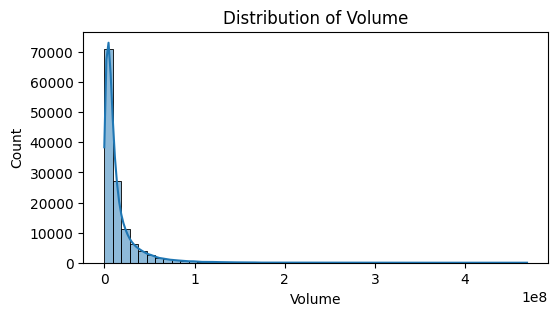

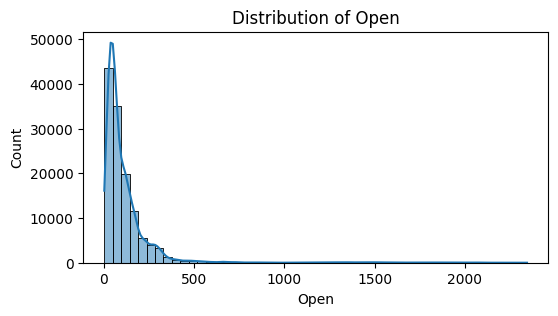

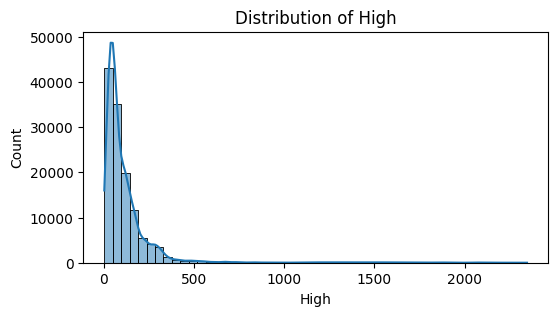

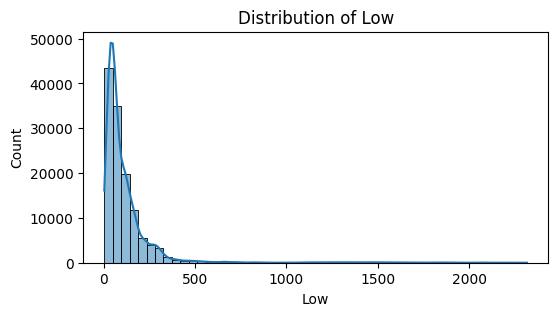

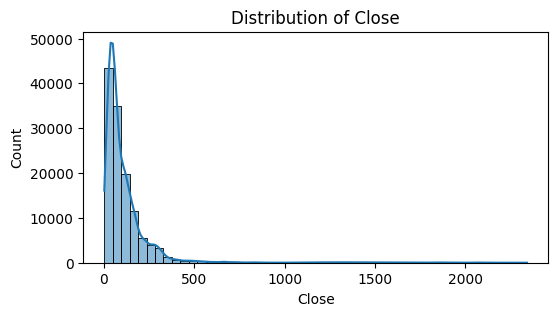

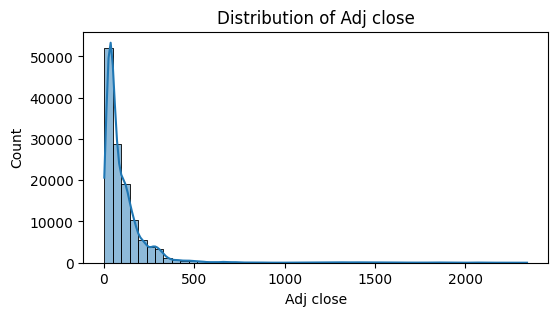

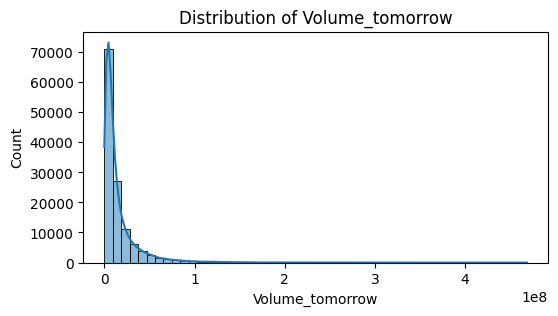

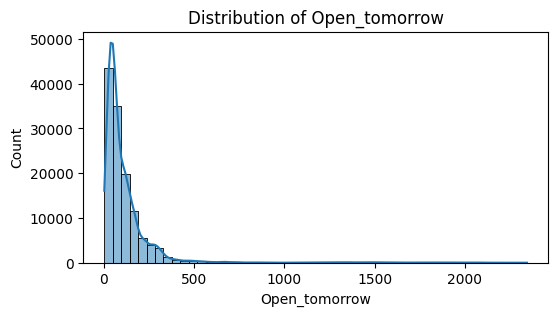

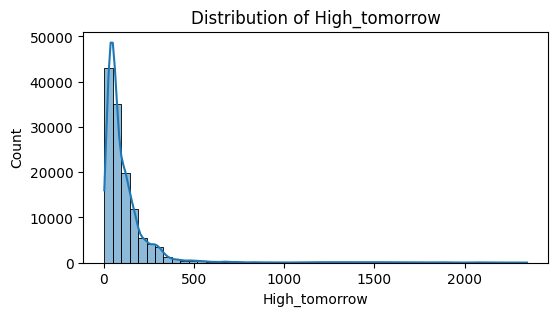

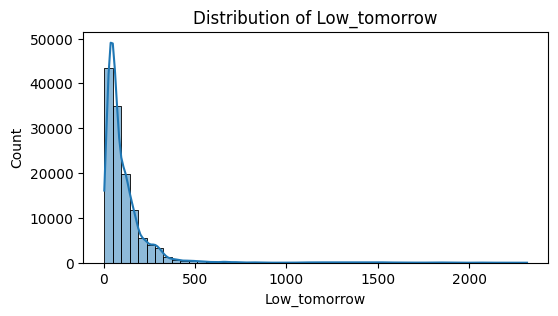

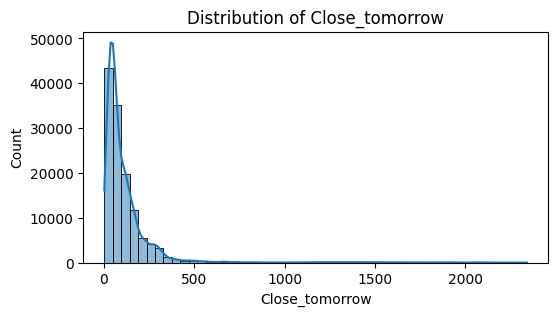

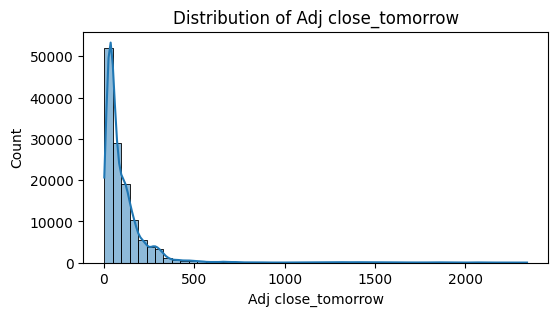

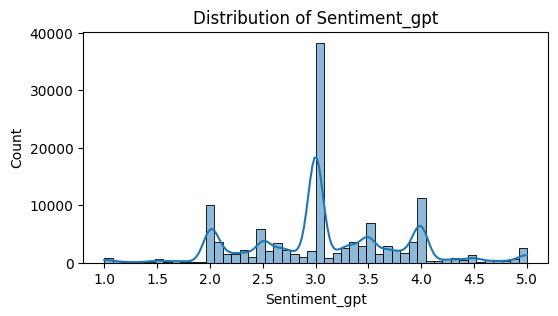

In [ ]:
num_cols = ['Volume',
            'Open',
            'High',
            'Low',
            'Close',
            'Adj close',
            'Volume_tomorrow',
            'Open_tomorrow',
            'High_tomorrow',
            'Low_tomorrow',
            'Close_tomorrow',
            'Adj close_tomorrow',
            'Sentiment_gpt']
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


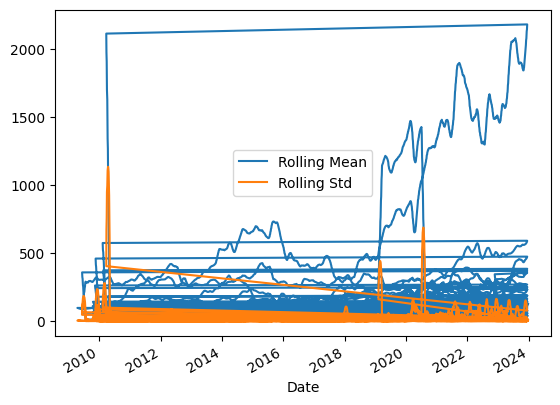

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df['Close'].rolling(window=30).mean().plot(label='Rolling Mean')
df['Close'].rolling(window=30).std().plot(label='Rolling Std')
plt.legend()
plt.show()

In [ ]:

result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
result = kpss(df['Close'])
print('KPSS Statistic: %f' % result[0])


ADF Statistic: -8.564484
KPSS Statistic: 1.270830


<ipython-input-38-08123e61e282>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df['Close'])


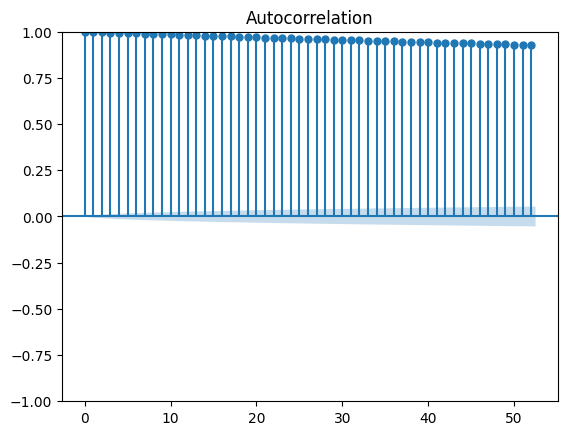

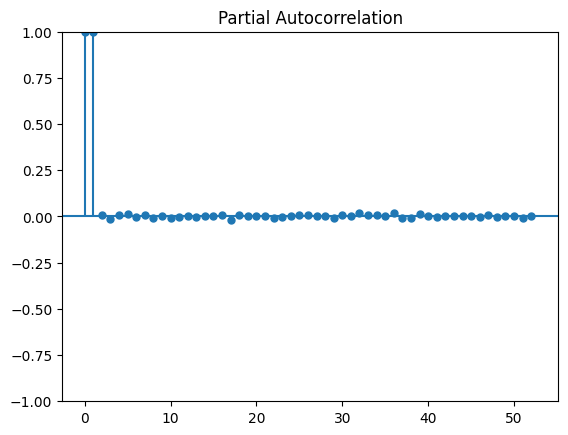

In [ ]:

plot_acf(df['Close'])
plot_pacf(df['Close'])
plt.show()


In [ ]:
# model = RandomForestRegressor()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train['Date'] = pd.to_datetime(X_train['Date']).map(pd.Timestamp.toordinal)
# X_test['Date'] = pd.to_datetime(X_test['Date']).map(pd.Timestamp.toordinal)

# model.fit(X_train, y_train)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

##1

In [ ]:

# shap.summary_plot(shap_values, X_test)


In [ ]:

importance = model.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))



NameError: name 'model' is not defined

In [ ]:

df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# News_flag class imbalance
print(df['News_flag'].value_counts(normalize=True) * 100)
sns.countplot(x='News_flag', data=df)
plt.title("News_flag Distribution")
plt.show()


In [ ]:

df['Date_diff'] = df['Date'].diff()
print(df['Date_diff'].value_counts())


In [ ]:

df['rolling_mean'] = df['Close'].rolling(window=30).mean()
df['rolling_std'] = df['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['rolling_mean'], label='Rolling Mean')
plt.plot(df['Date'], df['rolling_std'], label='Rolling Std')
plt.legend()
plt.title("Rolling Statistics")
plt.show()


In [ ]:

adf_result = adfuller(df['Close'].dropna())
kpss_result = kpss(df['Close'].dropna(), regression='c')
print(f"ADF p-value: {adf_result[1]}")
print(f"KPSS p-value: {kpss_result[1]}")


In [ ]:

# ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Close'].dropna(), lags=40)
plot_pacf(df['Close'].dropna(), lags=40)
plt.show()


In [ ]:

# News flag frequency
df['News_flag_date'] = df['News_flag'].where(df['News_flag'] == 1)
df['News_flag_date'] = df['News_flag_date'].fillna(0)
plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['News_flag_date'])
plt.title("News_flag Occurrence Over Time")
plt.show()


In [ ]:

df['Return'] = df['Close'].pct_change()
df['Lag_1'] = df['Return'].shift(1)
df['Lag_2'] = df['Return'].shift(2)

# RSI, MACD
import ta

df['RSI'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()
df['MACD'] = ta.trend.MACD(close=df['Close']).macd()


In [ ]:

# Correlation heatmap
corr = df[['Close', 'Volume', 'Lag_1', 'RSI', 'MACD']].corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Spearman Correlation Heatmap")
plt.show()


In [ ]:
print(df[['Close', 'Volume', 'Lag_1', 'RSI', 'MACD']].describe())


In [ ]:
sns.histplot(df['Close'], kde=True)
plt.title("Close Price Distribution")
plt.show()

sns.boxplot(df['Close'])
plt.title("Close Price Boxplot")
plt.show()


In [ ]:

df.dropna(inplace=True)
X = df[['Lag_1', 'Lag_2', 'RSI', 'MACD']]
y = df['Close'].shift(-1).dropna()
X = X.iloc[:-1, :]


In [ ]:

# SHAP
import shap
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

